# Expanse Notebook for Computational Analysis of Chromatin During Heart Development

This notebook will be used exclusively to perform expensive operations on Expanse. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import functions as f
from tqdm import tqdm

TTN_BIN = 4275
bin_map = f.load_bin_map('data/bin_map_human_100000.bed')
contact_matrix_zero = np.load('samples/contact_matrix_100kb_balanced_zeroed.npy')

In [3]:

def build_walk_index(contact_matrix):
    """
    Precompute for each node:
      - neighbors[i]: 1D int array of neighbors
      - cdfs[i]:      1D float array of cumulative probabilities
    """
    N = contact_matrix.shape[0]
    neighbors = [None]*N
    cdfs      = [None]*N

    for i in tqdm(range(N)):
        w = contact_matrix[i]
        idx = np.nonzero(w)[0]
        if idx.size == 0:
            neighbors[i] = np.empty(0, dtype=int)
            cdfs[i]      = np.empty(0, dtype=float)
        else:
            probs = w[idx] / w[idx].sum()
            neighbors[i] = idx
            cdfs[i]      = np.cumsum(probs)
    return neighbors, cdfs

neighbors, cdfs = build_walk_index(contact_matrix_zero) 



100%|██████████| 30894/30894 [00:26<00:00, 1170.47it/s]


### Random Walking Time Test


In [4]:
import functions as f

from time import time

start = time()


f.random_walk_fast(
    contact_matrix_zero, TTN_BIN, 5,
    neighbors=neighbors, cdfs=cdfs,
    num_molecules=10000, alpha=0.05
)
end = time()

print(f"Time taken: {end - start} seconds")

Time taken: 13.749757766723633 seconds


### Analytical Diffusion Test

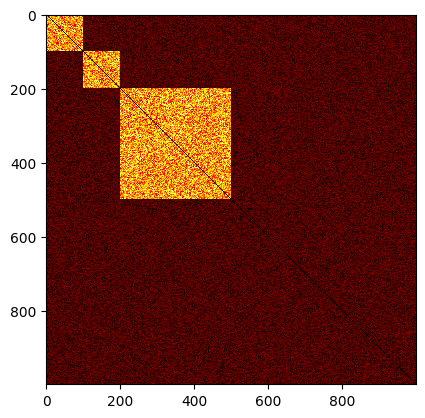

In [6]:
# create a sample matrix
sample_matrix = f.generate_sample_matrix_bins(1000)

# visualize the contact matrix hic 
plt.imshow(sample_matrix, cmap='hot', interpolation='nearest')
plt.show()


In [5]:
import numpy as np

def analytical_diffusion_clique(contact_matrix: np.ndarray,
                                start_node: int,
                                n: int,
                                alpha: float = 0.1):

    N = contact_matrix.shape[0]

    # 1) Build the row‑stochastic transition matrix P
    P = np.zeros((N, N), dtype=float)
    row_sums = contact_matrix.sum(axis=1)
    for i in range(N):
        if row_sums[i] > 0:
            P[i, :] = contact_matrix[i, :] / row_sums[i]
        else:
            # no neighbors → self‑loop
            P[i, i] = 1.0

    # 2) Form the fundamental matrix: F = (I - (1-alpha)*P)^(-1)
    I = np.eye(N)
    F = np.linalg.inv(I - (1 - alpha) * P)

    # 3) Extract the expected visits for a start at `start_node`
    visits = F[start_node, :]

    # 4) Pick the top‑n nodes by descending visits
    clique = np.argsort(visits)[-n:][::-1]
    return clique, visits

In [7]:
analytical_diffusion_clique(sample_matrix, start_node=4, n=6)

(array([  4, 100, 200,  42,  74,  81]),
 array([0.01199223, 0.01188153, 0.01156094, 0.01199587, 1.00939661,
        0.01184838, 0.01272356, 0.0110147 , 0.01343468, 0.01367528,
        0.01283314, 0.01218274, 0.01222661, 0.01264515, 0.01286483,
        0.01348764, 0.0129823 , 0.01165833, 0.01258589, 0.01176022,
        0.01426701, 0.01339998, 0.01306255, 0.01268986, 0.0122076 ,
        0.01351704, 0.01428483, 0.01257356, 0.01100249, 0.0139293 ,
        0.01269072, 0.01109104, 0.01310731, 0.01132308, 0.01373399,
        0.01360067, 0.01265406, 0.01214422, 0.01260835, 0.0130123 ,
        0.01360158, 0.01230992, 0.01494291, 0.01271929, 0.014155  ,
        0.01383386, 0.01267074, 0.01361424, 0.01262122, 0.01382339,
        0.01348634, 0.01296143, 0.01340601, 0.01393804, 0.01350907,
        0.01322838, 0.01348901, 0.01184442, 0.01232954, 0.01317171,
        0.01234528, 0.01208239, 0.01380647, 0.0126891 , 0.01319997,
        0.01109702, 0.01197367, 0.01221787, 0.01322315, 0.01277231,
        